# PROJEKT MODELU REGRESYJNEGO PRZEWIDYWANIA CEN MIESZKAŃ NA PODSTAWIE #

# ALGORYTMU LGBM #

  ## KWIECIEŃ 2025 ##

In [1]:
import pandas as pd
from pycaret.regression import setup, pull, compare_models, plot_model
import pymysql
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# tą komórkę uruchom jeżeli bazie bierzesz np. z DBeaver
username = 'root'
password = '1234'
host = '127.0.0.1'
port = 3306  
database = 'projekt1'
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

df = pd.read_sql("SELECT * FROM saleflats", con=engine)

engine.dispose()

In [2]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df = pd.read_csv('saleflats_3.csv', sep=',')

In [3]:
df

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,NaN,692985.0,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,NaN,3500000.0,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,NaN,NaN,1885000.0,...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,NaN,950000.0,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,1043500.00,1322333.33,NaN,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=
104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,629000.00,651666.67,NaN,...,NaN,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Stru...",14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=
104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,782389.08,875268.63,NaN,...,NaN,"Mazowieckie, Warszawa, Ursus",14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=
104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,1499000.00,1579933.33,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=


In [4]:
df.head(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,NaN,692985.0,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,NaN,3500000.0,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,NaN,NaN,1885000.0,...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,NaN,950000.0,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
5,50344,NaN,3,Nowe/ 4 pok/2 poziomy/ centrum/ stan deweloperski,"Oferuje na sprzedaż niezwykłe, czteropokojowe ...",139.62,4500000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Mikoła...",14,65,10.0,8.0,919810.0,NaN,9282.0,15LmMjMJbn-QWhfW8gV2vL1cwColzIKnjrh_K5zWcDs=
6,50536,NaN,3,3-pokojowe mieszkanie 77m2 + balkon Bez Prowizji,3-pokojowe mieszkanie numer 84 na 6. piętrze w...,77.37,1400397.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Mokotów, Ul. Powsińska",14,65,5.0,8.0,918130.0,NaN,17335.0,HR1IZtDzHqO744taep4TeL1cwColzIKnjrh_K5zWcDs=
7,50589,NaN,3,Mieszkanie na cele biurowe w Centrum,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM WARSZ...,197.46,3500000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,6xTtoWiCP98SdH8KWVykTL1cwColzIKnjrh_K5zWcDs=
8,50728,NaN,18,"Mieszkanie na sprzedaż, 94 m2, Warszawa","Prestiżowa lokalizacja w centrum, elegancki bu...",94.00,1900000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,IGTIkU-I2aB9W4ZoexxdX71cwColzIKnjrh_K5zWcDs=
9,52961,NaN,3,Mieszkanie na cele biurowe i mieszkaniowe,MIESZKANIE W ZABYTKOWEJ KAMIENICY Z WINDĄ Wyso...,158.36,4592440.0,NaN,NaN,4750800.0,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Stanis...",14,65,10.0,8.0,919810.0,NaN,14289.0,r3dMz5c25UdXhS5fYW6teL1cwColzIKnjrh_K5zWcDs=


In [5]:
df.sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
73730,3803952,NaN,32,"Mieszkanie Warszawa gm. Mokotów Mokotów, Warszawa",Mam na sprzedaż mieszkanie 2-pokojowe o powier...,44.00,650000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Mokotów",14,65,5.0,8.0,NaN,NaN,NaN,-JcYC1z7kJ1ewKrt2yzhOwDdKxtGNfzGFAfeT2xucQg=
41316,3143075,NaN,14,Nowe mieszkanie trzypokojowe(NrRR_6A_A_1_1) Ro...,"Royal Residence to enklawa nowoczesnych, niski...",72.19,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wilanów, Ul. Sarmacka",14,65,16.0,8.0,988856.0,NaN,19532.0,lWbj1ubkuY79aVEvvXvfrkC1A5rJxePvoARfV4ub4KM=
30750,2960728,NaN,17,"Mieszkanie, ul. Krasnobrodzka","3 oddzielne pokoje I 58,4 m2 I Możliwość zakup...",58.40,748000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Targówek, Ul. Krasnobro...",14,65,11.0,8.0,988827.0,NaN,9856.0,7UVHy3gKNeKBL-iyxR5LW4_bCM8lJ876moazm9h2OAo=
39649,3111365,NaN,17,Mieszkanie Warszawa,"3 POKOJE/61 mkw z LOGGIĄ i GARAŻEM, NA STAREJ ...",61.36,1150000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Ochota",14,65,6.0,8.0,NaN,NaN,NaN,gOMQ2oZNKHHiblUJz4X51yykkO2XD8llNorSA-9-Byw=
92686,4191767,NaN,3,Balkon 10M | Garderoba | Klucze W Tym Roku,"Mieszkanie 3 pokojowe - 53,53m2 + BALKON 9m2 P...",64.00,978362.0,NaN,NaN,998968.0,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Kamionek",14,65,7.0,8.0,918940.0,NaN,NaN,JJ7bwSOg3NAP6jSkK2CiOe8e0oyGIwz8-GAUcMCH2_k=
103122,4333317,NaN,22,Sprzedam mieszkanie Warszawa - Wola niecełe 10...,OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Mieszka...,38.00,550000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,P15qU8pIfJoGCkIhn3uDO5P7_4V7ShzJmmF8PHTVfng=
21967,2830644,NaN,2,Mieszkanie na sprzedaż,Olchowy Park 7 to wyjątkowy projekt mieszkanio...,44.42,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Mańkowska",14,65,3.0,8.0,988796.0,NaN,12243.0,chHKZny7Xh2ui3Mi8ul1kjhfYAZgb9FMrSOG2614fgQ=
72958,3787757,NaN,3,Pilnie! 2 pokoje z widokiem na panoramę miasta!,"Obniżona cena ze względu na pilną sprzedaż, of...",39.00,659000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Fabryczna",14,65,10.0,8.0,919810.0,NaN,4863.0,qSQlRxqEUpAVH3JNbk-cb2rEJkU2QT-yp-az_9WBzEQ=
82474,4000158,NaN,32,Sprzedam Warszawa,UWAGA⚠️ Dwupokojowe mieszkanie w Warszawie za ...,45.00,499000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Białołęka",14,65,3.0,8.0,NaN,NaN,NaN,jJ7lqamB448R9qcmjEL9XSFhR9uKFSRu990qiyDp3Xk=
88241,4115426,NaN,38,Mieszkanie 3 pokojowe,Oferta aktualna - możliwość umówienia bezpiecz...,64.50,896550.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Białołęka",14,65,3.0,8.0,NaN,NaN,NaN,SmuaydAlg5sr0yMijmWs4gw0XdZpdElsyo2tO3t9Cik=


In [6]:
df.info

<bound method DataFrame.info of          SaleId  OriginalId  PortalId  \
0          1509         NaN         3   
1         47402         NaN        18   
2         47635         NaN         3   
3         49614         NaN        17   
4         50256         NaN        17   
...         ...         ...       ...   
104577  4347957         NaN        22   
104578  4347959         NaN         2   
104579  4347996         NaN         2   
104580  4348007         NaN        38   
104581  4348020         NaN        19   

                                                    Title  \
0       2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji   
1                 Mieszkanie na sprzedaż, 37 m2, Warszawa   
2                Na Cele Biurowe | Parking | Klimatyzacja   
3                               Apartament, ul. Kasprzaka   
4                            Apartament, ul. Mikołajczyka   
...                                                   ...   
104577  Warszawa/Żoliborz/Braci Załuskich 60m2, 

In [7]:
df[df.duplicated()]

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId


In [8]:
df.nunique()

SaleId                       104582
OriginalId                        0
PortalId                         16
Title                         58748
Description                   92083
Area                           7684
Price                         13414
OfferPrice                     3034
RealPriceAfterRenovation       4144
OriginalPrice                  2915
PricePerSquareMeter           43896
NumberOfRooms                    38
BuiltYear                       162
Type                              1
BuildingType                      4
BuildingCondition                 4
OfferFrom                         2
Floor                            45
Floors                           47
TypeOfMarket                      2
OwnerType                        40
DateAddedToDatabase          102295
DateAdded                    102326
DateLastModification          28868
DateLastRaises                39750
NewestDate                   102535
AvailableFrom                     0
Link                        

In [9]:
correlation_matrix = df[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore']].corr()

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

Text(0.5, 1.0, 'Correlation Matrix of Price')

In [11]:
df.isnull()

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,False,True,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
1,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
2,False,True,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
3,False,True,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
4,False,True,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,True,True,True,True,False
104578,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,True,False,False
104579,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,True,True,True,False
104580,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,True,True,True,False


In [12]:
df.isnull().sum()

SaleId                            0
OriginalId                   104582
PortalId                          0
Title                             0
Description                      83
Area                            224
Price                          7158
OfferPrice                    95659
RealPriceAfterRenovation      95659
OriginalPrice                 90525
PricePerSquareMeter            7533
NumberOfRooms                  1770
BuiltYear                     14172
Type                              0
BuildingType                  25263
BuildingCondition             98057
OfferFrom                      1389
Floor                          3386
Floors                        17833
TypeOfMarket                   1668
OwnerType                     47995
DateAddedToDatabase               0
DateAdded                         0
DateLastModification          75510
DateLastRaises                64374
NewestDate                        0
AvailableFrom                104582
Link                        

In [13]:
df_beznull_price = df.dropna(subset=['Area'])

In [14]:
df_beznull_price.isnull().sum()

SaleId                            0
OriginalId                   104358
PortalId                          0
Title                             0
Description                      79
Area                              0
Price                          7151
OfferPrice                    95435
RealPriceAfterRenovation      95435
OriginalPrice                 90306
PricePerSquareMeter            7310
NumberOfRooms                  1559
BuiltYear                     13965
Type                              0
BuildingType                  25129
BuildingCondition             97835
OfferFrom                      1374
Floor                          3184
Floors                        17629
TypeOfMarket                   1645
OwnerType                     47838
DateAddedToDatabase               0
DateAdded                         0
DateLastModification          75295
DateLastRaises                64157
NewestDate                        0
AvailableFrom                104358
Link                        

In [15]:
df_beznull_price

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,NaN,692985.0,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,NaN,3500000.0,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,NaN,NaN,1885000.0,...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,NaN,950000.0,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,1043500.00,1322333.33,NaN,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=
104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,629000.00,651666.67,NaN,...,NaN,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Stru...",14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=
104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,782389.08,875268.63,NaN,...,NaN,"Mazowieckie, Warszawa, Ursus",14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=
104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,1499000.00,1579933.33,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=


In [16]:
Q1 = df_beznull_price["Price"].quantile(0.25)
Q3 = df_beznull_price["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_p = df_beznull_price[~((df_beznull_price["Price"] < lower_bound) | (df_beznull_price["Price"] > upper_bound))]

In [17]:
Q1 = df_price_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_price_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_a = df_price_p[~((df_price_p["PricePerSquareMeter"] < lower_bound) | (df_price_p["PricePerSquareMeter"] > upper_bound))]


In [18]:
Q1 = df_price_a["Area"].quantile(0.25)
Q3 = df_price_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price1 = df_price_a[~((df_price_a["Area"] < lower_bound) | (df_price_a["Area"] > upper_bound))]

In [19]:
df_beznull_price.describe().T

,count,mean,std,min,25%,50%,75%,max
SaleId,104358.0,3.298142e+06,7.511956e+05,1509.00,2886883.25,3339674.00,3904346.00,4.348020e+06
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,104358.0,1.115259e+01,9.839886e+00,2.00,3.00,10.00,17.00,4.400000e+01
Area,104358.0,6.580422e+01,1.713750e+03,5.00,39.30,50.64,65.02,5.230000e+05
Price,97207.0,1.086521e+06,5.050943e+06,1.00,670000.00,845000.00,1159000.00,1.000000e+09
OfferPrice,8923.0,9.706371e+05,5.716421e+05,308000.00,668697.25,802500.00,1060869.50,9.600000e+06
RealPriceAfterRenovation,8923.0,1.635752e+06,9.848497e+06,328275.00,805000.00,1014996.67,1430000.00,3.342342e+08
OriginalPrice,14052.0,3.060065e+34,3.627436e+36,555.00,680000.00,849000.00,1150000.00,4.300003e+38
PricePerSquareMeter,97048.0,1.904071e+04,1.186708e+05,0.01,14838.71,17320.00,20594.97,2.500000e+07
NumberOfRooms,102799.0,1.096724e+04,2.493835e+06,1.00,2.00,2.00,3.00,6.088201e+08


In [20]:
df_price1.describe().T

,count,mean,std,min,25%,50%,75%,max
SaleId,91394.0,3.304206e+06,7.425786e+05,1509.00,2889165.500,3344563.50,3904532.50,4.347996e+06
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,91394.0,1.119002e+01,9.884173e+00,2.00,3.000,10.00,17.00,4.400000e+01
Area,91394.0,5.067054e+01,1.577021e+01,9.50,38.500,48.79,60.67,9.679000e+01
Price,84594.0,8.646235e+05,2.991214e+05,79500.00,650000.000,799000.00,999000.00,1.892000e+06
OfferPrice,7983.0,8.538240e+05,2.986201e+05,308000.00,650000.000,788580.50,970000.00,3.850000e+06
RealPriceAfterRenovation,7983.0,1.484180e+06,1.037829e+07,328275.00,785029.335,979626.67,1282333.33,3.342342e+08
OriginalPrice,12540.0,9.517657e+05,7.672791e+06,555.00,665000.000,810000.00,1015000.00,8.590000e+08
PricePerSquareMeter,84441.0,1.742983e+04,3.632681e+03,6818.18,14747.780,16981.01,19747.24,2.777984e+04
NumberOfRooms,90086.0,1.251444e+04,2.663993e+06,1.00,2.000,2.00,3.00,6.088201e+08


In [21]:
df_price1["Price"].value_counts(normalize=True)

Price
799000.0     0.012389
699000.0     0.012341
750000.0     0.010036
650000.0     0.009906
899000.0     0.009823
               ...   
875366.0     0.000012
680036.0     0.000012
907812.0     0.000012
1510667.0    0.000012
775286.0     0.000012
Name: proportion, Length: 11131, dtype: float64

In [22]:
df_price1.sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
1368,1534906,NaN,19,"Sprzedam kawalerkę ul Sierpińskiego Ochota, 36m2","Sprzedam kawalerkę 36m2 z otwartą kuchnią, duż...",36.00,650000.0,NaN,NaN,690000.0,...,NaN,"Mazowieckie, Warszawa, Ochota",14,65,6.0,8.0,918643.0,NaN,NaN,j1gh54npeuhvztUriRLlllxslNBbpBprsR-39HjnMC8=
92029,4182188,NaN,3,Mieszkanie 2 Pok. Prestiżowa Lokalizacja,"TYLKO U NAS! Nie czekaj, umów się na prezentac...",45.46,999000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Leszcz...",14,65,10.0,8.0,919810.0,NaN,10873.0,0f7lQsma4KUmhrf8r1yrBE2T1CD5iVD5QFRdTTszASs=
44282,3197527,NaN,18,"2 pokoje ul. Szymanowskiego, Plac Hallera.","NA SPRZEDAŻ! 2 pokoje, ul. Karola Szymanowskie...",56.20,785000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Praga-północ, Ul. Karol...",14,65,8.0,8.0,919298.0,NaN,22238.0,-quYM6SuVT_5ABCNErp2I4aCdEfvBnZExzKfPS9GXW0=
66499,3659303,NaN,17,Mieszkanie Warszawa,Jeżeli szukasz przestrzeni i dobrze oświetlone...,47.50,937000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Bielany, Inne Stacja Me...",14,65,4.0,8.0,988804.0,NaN,48057.0,Rtq2-GuOT-bzjeAI-QDwO9mt8jYoYSSb1fbxc0kdY_c=
83382,4020510,NaN,3,1-pokojowe mieszkanie 25m2 + balkon,1-pokojowe mieszkanie numer J1_35 na 3. piętrz...,25.64,415368.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Rembertów, Ul. Chełmżyńska",14,65,9.0,8.0,988810.0,NaN,2710.0,Suh0A5S8hgiXK1HhrSdQmWb3MhONsWHx4CM5o0osslE=
37435,3082593,NaN,11,"Mieszkanie, Warszawa, Wola, 55 m²","Mieszkanie, Warszawa, Wola, 55 m² Ogłoszenioda...",54.75,880000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wola",14,65,18.0,8.0,NaN,NaN,NaN,x1n0ZGmQiRrMqjIUqOiZDULWB3gJBEE3JSbYoi1MtPg=
30521,2956494,NaN,11,"Mieszkanie, Warszawa, Śródmieście, 34 m²","Mieszkanie, Warszawa, Śródmieście, 34 m² Ogłos...",33.75,650000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,7ehwWVImwEDvSugEitgZAmDSFhxJitH2UJuyXKHVWIY=
66334,3656123,NaN,11,"Mieszkanie, Warszawa, Wawer, 41 m²","Mieszkanie, Warszawa, Wawer, 41 m² Ogłoszeniod...",41.00,580000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wawer",14,65,14.0,8.0,NaN,NaN,NaN,0fukgQCaiA7uvGMdGQ51mnkQLtO0GZiQYI-xZORsCC4=
44257,3197165,NaN,3,"B. ładne,Sady Żoliborskie,2018r., garaż !",Polecam ! Zdjęcia nie odzwierciedlają w pełni ...,43.28,1125000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Żoliborz, Ul. Przasnyska",14,65,19.0,8.0,920048.0,NaN,17618.0,HpihjaclpfRhvkJ9Yc61aSykkO2XD8llNorSA-9-Byw=
98055,4266900,NaN,3,"3 pokoje, kuchnia, Metro Wawrzyszew 200m","Mieszkanie na sprzedaż, Warszawa, Bielany, ul....",48.00,670000.0,699000.0,789333.0,NaN,...,NaN,"Mazowieckie, Warszawa, Bielany, Wrzeciono, Ul....",14,65,4.0,8.0,1067696.0,NaN,24849.0,EYshMgq-WWLz6RoEGUC-qFcgSx7sGm5nUpo5FzVSNNM=


In [23]:
df_price1.nunique()

SaleId                       91394
OriginalId                       0
PortalId                        16
Title                        50855
Description                  80187
Area                          5960
Price                        11131
OfferPrice                    2636
RealPriceAfterRenovation      3646
OriginalPrice                 2389
PricePerSquareMeter          37767
NumberOfRooms                   29
BuiltYear                      153
Type                             1
BuildingType                     4
BuildingCondition                4
OfferFrom                        2
Floor                           30
Floors                          38
TypeOfMarket                     2
OwnerType                       39
DateAddedToDatabase          89523
DateAdded                    89573
DateLastModification         25086
DateLastRaises               34578
NewestDate                   89783
AvailableFrom                    0
Link                         91385
Phone               

In [24]:
unique_btype=df_price1['BuildingType'].unique()

unique_btype

array([nan, 'Kamienica', 'Apartamentowiec', 'Blok', 'Pozostałe'],
      dtype=object)

In [25]:
print(df_price1['Price'].nunique())

11131


In [26]:
print(df_price1['Price'].value_counts())

Price
799000.0     1048
699000.0     1044
750000.0      849
650000.0      838
899000.0      831
             ... 
875366.0        1
680036.0        1
907812.0        1
1510667.0       1
775286.0        1
Name: count, Length: 11131, dtype: int64


In [27]:
df_price1.isnull().sum()

SaleId                           0
OriginalId                   91394
PortalId                         0
Title                            0
Description                     69
Area                             0
Price                         6800
OfferPrice                   83411
RealPriceAfterRenovation     83411
OriginalPrice                78854
PricePerSquareMeter           6953
NumberOfRooms                 1308
BuiltYear                    12269
Type                             0
BuildingType                 23055
BuildingCondition            85640
OfferFrom                     1317
Floor                         2756
Floors                       15638
TypeOfMarket                  1314
OwnerType                    41921
DateAddedToDatabase              0
DateAdded                        0
DateLastModification         66148
DateLastRaises               56483
NewestDate                       0
AvailableFrom                91394
Link                             0
Phone               

In [28]:
df_price2 = df_price1.dropna(subset=['Price'])

In [29]:
df_price2.isnull().sum()

SaleId                           0
OriginalId                   84594
PortalId                         0
Title                            0
Description                     67
Area                             0
Price                            0
OfferPrice                   76611
RealPriceAfterRenovation     76611
OriginalPrice                72054
PricePerSquareMeter            153
NumberOfRooms                 1308
BuiltYear                    11148
Type                             0
BuildingType                 17538
BuildingCondition            79546
OfferFrom                       70
Floor                         2725
Floors                       14509
TypeOfMarket                  1277
OwnerType                    38783
DateAddedToDatabase              0
DateAdded                        0
DateLastModification         59401
DateLastRaises               52298
NewestDate                       0
AvailableFrom                84594
Link                             0
Phone               

In [30]:
correlation_matrix = df_price2[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

Text(0.5, 1.0, 'Correlation Matrix of Price')

In [31]:
exp = setup(
    data=df_price2,
    target='Price',
    session_id=1122,
    verbose=False,
    categorical_features=[
        'BuildingType',
        'BuildingCondition',
         ],
    keep_features=[
        'Location',
        'Area',
         ],
    ignore_features=[
        'SaleId',
        'RealPriceAfterRenovation',
        'OfferPrice',
        'OriginalPrice',
        'PricePerSquareMeter',
        'OriginalId',
        'PortalId',
        'Title',
        'Type',
        'OfferFrom',
        'TypeOfMarket',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'Score',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
    ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica'],
                      'BuildingCondition': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State' ]},
        
       
)
exp.dataset_transformed.sample(10)

,Description,Area,NumberOfRooms,BuiltYear,BuildingType_1.0,BuildingType_-1.0,BuildingType_3.0,BuildingType_0.0,BuildingCondition_-1.0,Floor,Floors,Location,Price
3080,Unikalne mieszkanie na poddaszu – Przestrzeń i...,78.300003,4.0,1956.000000,0.0,0.0,1.0,0.0,1.0,3.000000,3.00000,"Mazowieckie, Warszawa, Włochy, Ul. Nike",1015000.0
80368,"Kawalerka 31,97 m² do remontu – Warszawa, ul. ...",31.969999,1.0,1975.000000,1.0,0.0,0.0,0.0,1.0,6.000000,10.00000,"Mazowieckie, Warszawa, Targówek, Ul. Smoleńska",470000.0
64816,2-pokojowe mieszkanie zlokalizowane na Żolibor...,37.320000,2.0,2016.000000,1.0,0.0,0.0,0.0,1.0,4.000000,4.00000,"Mazowieckie, Warszawa, Żoliborz, Ul. Kaliny Ję...",995000.0
8835,1 pokojowe mieszkanie zlokalizowane na Pradze-...,40.000000,1.0,2001.000000,1.0,0.0,0.0,0.0,1.0,2.000000,6.46827,"Mazowieckie, Warszawa, Praga-południe, Ul. Cza...",670000.0
52233,POLISH ABOVE / ENGLISH BELOW Oferujemy na sprz...,26.000000,2.0,1972.000000,1.0,0.0,0.0,0.0,1.0,7.000000,18.00000,"Mazowieckie, Warszawa, Wola",660000.0
1033,Biuro nieruchomości Pure Estates ma przyjemnoś...,42.860001,2.0,1963.000000,1.0,0.0,0.0,0.0,1.0,1.000000,4.00000,"Mazowieckie, Warszawa, Praga-południe, Grochów",698000.0
46059,2 pokojowe mieszkanie ul. Targowa Praga-Północ...,43.000000,2.0,1912.000000,1.0,0.0,0.0,0.0,1.0,1.000000,3.00000,"Mazowieckie, Warszawa, Praga-północ, Ul. Targowa",980000.0
62653,Apartament z antresolą i tarasem Przedstawiamy...,84.000000,4.0,2025.000000,1.0,0.0,0.0,0.0,1.0,3.000000,3.00000,"Mazowieckie, Warszawa, Białołęka, Tarchomin",1062000.0
42713,"NAJLEPSZE CENY, WYSOKI STANDARD , BEZ PROWIZJI...",32.000000,2.0,1994.556396,1.0,0.0,0.0,0.0,1.0,3.161253,6.46827,"Mazowieckie, Warszawa, Praga-południe, Grochów",573000.0
28451,Biuro nieruchomości FindSQUARE ma przyjemność ...,50.000000,2.0,2005.000000,1.0,0.0,0.0,0.0,1.0,0.000000,3.00000,"Mazowieckie, Warszawa",899000.0


In [32]:
unbalanced_exp = setup(
    data=df_price2,
    target='Price',
    verbose=False,
    session_id=1122,
    categorical_features=[
        'BuildingType',
        'BuildingCondition',
         ],
    keep_features=[
        'Location',
        'Area',
         ],
    ignore_features=[
        'SaleId',
        'RealPriceAfterRenovation',
        'OfferPrice',
        'OriginalPrice',
        'PricePerSquareMeter',
        'OriginalId',
        'PortalId',
        'Title',
        'Type',
        'OfferFrom',
        'TypeOfMarket',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'Score',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
    ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica'],
                      'BuildingCondition': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State' ]},
)
best_unbalanced_model = unbalanced_exp.compare_models()
unbalanced_metrics_df = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,88506.6666,15554224007.5689,124705.9540,0.8270,0.1366,0.1038,1.5930
dummy,Dummy Regressor,232741.4594,89969720524.8000,299932.6094,-0.0002,0.3365,0.2929,0.4550


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 794, in compare_models
    model, model_fit_time = self._create_model(**create_model_args)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 1533, in _create_model
    model, model_fit_time, model_results, _ = self._create_model_with_cv(
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py", line 1126, in _create_model_with_cv
    scores = cross_validate(
             ^^^^^^^^^^^^^^^
  File "C:\Users\Ai\AppData\Local\miniconda3\envs\projekt1\Lib\site-packages\sklearn\util

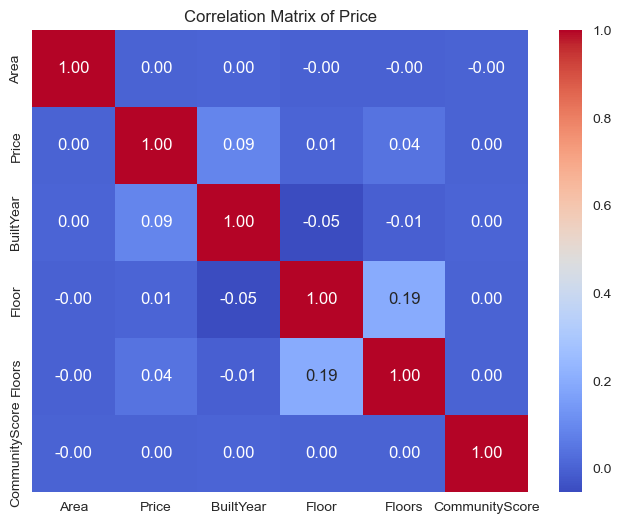

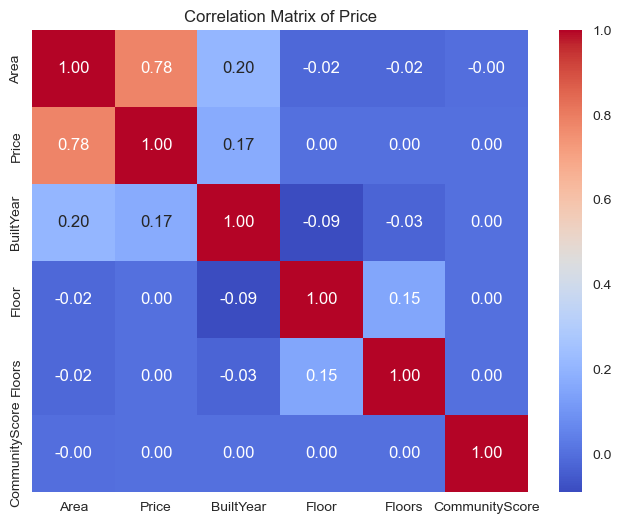

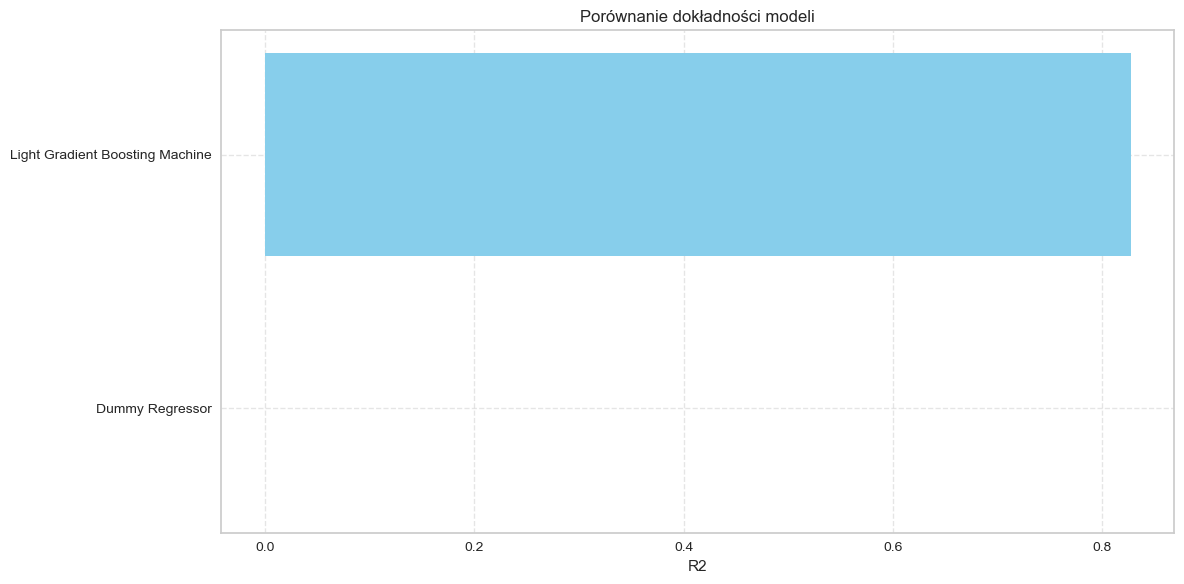

In [33]:
plt.figure(figsize=(12, 6))
plt.barh(unbalanced_metrics_df['Model'], unbalanced_metrics_df['R2'], color='skyblue')
plt.xlabel('R2')
plt.title('Porównanie dokładności modeli')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

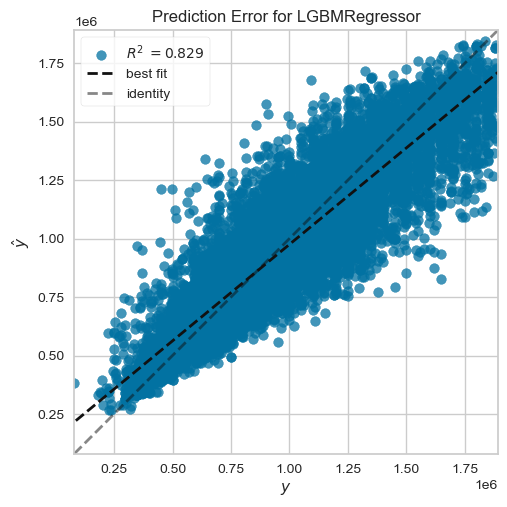

In [34]:
exp.plot_model(best_unbalanced_model, plot='error')

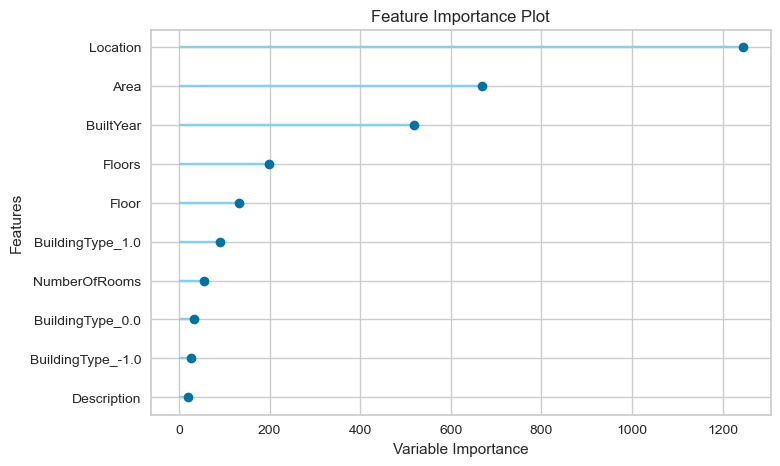

In [35]:
exp.plot_model(best_unbalanced_model, plot='feature')

In [36]:
tuned_model = exp.tune_model(best_unbalanced_model, n_iter=3, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,89118.8333,15599686913.7695,124898.7066,0.8267,0.1373,0.1045
1,89603.2666,15905492548.0875,126116.9796,0.8228,0.1390,0.1051
2,90929.0255,16184449118.3806,127218.1163,0.8256,0.1366,0.1046
3,88648.4679,15637744725.8426,125050.9685,0.8251,0.1388,0.1048
4,87792.7905,15054328541.3956,122696.0820,0.8329,0.1379,0.1048
5,90591.0971,16337666208.1529,127818.8805,0.8211,0.1444,0.1086
6,88777.7915,15465403187.4343,124359.9742,0.8228,0.1374,0.1052
7,88952.4741,15896436392.5234,126081.0707,0.8200,0.1357,0.1029
8,88812.5733,15347794654.6618,123886.2166,0.8245,0.1354,0.1040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [37]:
best_model = exp.compare_models([best_unbalanced_model, tuned_model])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,88506.6666,15554224007.5689,124705.9540,0.8270,0.1366,0.1038,0.9080
1,Light Gradient Boosting Machine,88506.6666,15554224007.5689,124705.9540,0.8270,0.1366,0.1038,0.9430


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

In [38]:
exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,87172.7443,15075587602.4233,122782.6845,0.8293,0.1353,0.1025


,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Price,prediction_label
53051,PRZYJAZNE MIESZKANIE 2-POKOJOWE Z WIDOKIEM NA ...,49.000000,2.0,1971.0,Blok,NaN,5.0,10.0,"Mazowieckie, Warszawa, Praga-południe, Ul. Mię...",880000.0,8.287186e+05
20512,Sprzedam Mieszkanie w Doskonałej Lokalizacji n...,35.000000,2.0,NaN,Blok,NaN,6.0,NaN,"Mazowieckie, Warszawa, Ochota",609000.0,6.532371e+05
292,4-pokojowe mieszkanie numer 28A na 1. piętrze ...,73.000000,4.0,NaN,NaN,NaN,1.0,2.0,"Mazowieckie, Warszawa, Białołęka, Ul. Gioacchi...",796650.0,1.011328e+06
28836,"Na sprzedaż oferuję przestronne, 3-pokojowe mi...",62.000000,3.0,2024.0,Apartamentowiec,NaN,0.0,3.0,"Mazowieckie, Warszawa, Białołęka, Białołęka Dw...",744000.0,9.114816e+05
5000,Lento Warszawa Nieruchomości Mieszkania Sprzed...,62.000000,2.0,2009.0,Blok,NaN,2.0,NaN,"Mazowieckie, Warszawa, Białołęka",629000.0,8.673058e+05
...,...,...,...,...,...,...,...,...,...,...,...
17762,Zapraszamy do zapoznania się z ofertą sprzedaż...,41.000000,2.0,1973.0,Blok,NaN,7.0,10.0,"Mazowieckie, Warszawa, Żoliborz, Ul. Sady Żoli...",680000.0,6.891951e+05
81854,Sprzedam 2 pokojowe mieszkanie o powierzchni 3...,37.000000,2.0,1974.0,Blok,NaN,1.0,10.0,"Mazowieckie, Warszawa, Mokotów, Ul. Korczyńska",739000.0,6.386974e+05
5466,"Mieszkanie, Warszawa, Ursynów, 49 m² Ogłoszeni...",48.730000,2.0,2020.0,Blok,NaN,2.0,NaN,"Mazowieckie, Warszawa",899000.0,9.086611e+05
38007,Oferta aktualna - możliwość umówienia bezpiecz...,64.000000,3.0,1978.0,Blok,NaN,10.0,10.0,"Mazowieckie, Warszawa, Bemowo",849000.0,8.476011e+05


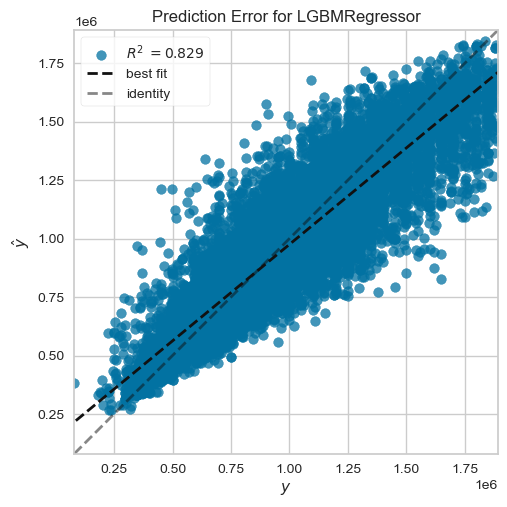

In [39]:
exp.plot_model(best_model, plot='error')

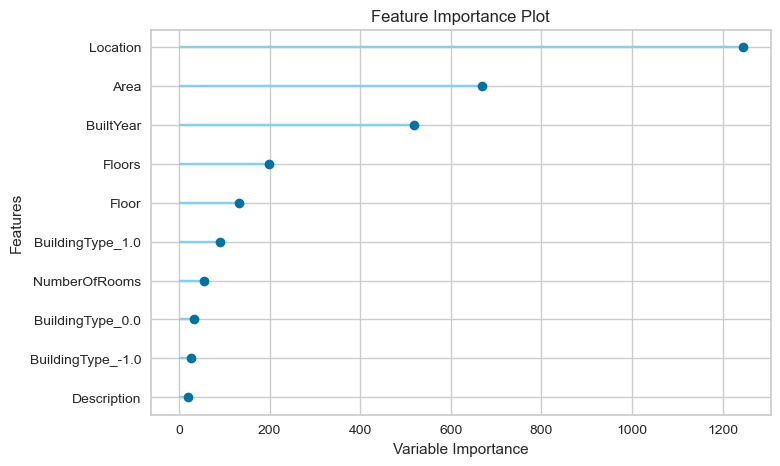

In [40]:
exp.plot_model(best_model, plot='feature')

In [41]:
best_tuned_model = exp.tune_model(
    best_model,
    optimize="R2",
    choose_better=True,
    fold=10,
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,84519.5438,14318365419.8222,119659.3725,0.8409,0.1318,0.0991
1,85297.1050,14727585049.9606,121357.2620,0.8360,0.1335,0.0999
2,86499.1169,14786352521.5577,121599.1469,0.8407,0.1312,0.0998
3,84828.0539,14421309086.8755,120088.7550,0.8387,0.1331,0.0998
4,83083.4493,13647312760.6598,116821.7136,0.8485,0.1313,0.0990
5,86760.4469,15292412246.3047,123662.4933,0.8325,0.1395,0.1036
6,84947.2758,14324360767.3028,119684.4216,0.8358,0.1329,0.1008
7,84345.4116,14393555928.2737,119973.1467,0.8371,0.1300,0.0978
8,84694.7059,14188606425.5065,119115.9369,0.8377,0.1303,0.0991


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [42]:
exp.predict_model(best_tuned_model).head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,83461.8872,13939610055.7086,118066.1258,0.8421,0.1309,0.0985


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Price,prediction_label
53051,PRZYJAZNE MIESZKANIE 2-POKOJOWE Z WIDOKIEM NA ...,49.000000,2.0,1971.0,Blok,NaN,5.0,10.0,"Mazowieckie, Warszawa, Praga-południe, Ul. Mię...",880000.0,8.107662e+05
20512,Sprzedam Mieszkanie w Doskonałej Lokalizacji n...,35.000000,2.0,NaN,Blok,NaN,6.0,NaN,"Mazowieckie, Warszawa, Ochota",609000.0,6.599967e+05
292,4-pokojowe mieszkanie numer 28A na 1. piętrze ...,73.000000,4.0,NaN,NaN,NaN,1.0,2.0,"Mazowieckie, Warszawa, Białołęka, Ul. Gioacchi...",796650.0,9.485488e+05
28836,"Na sprzedaż oferuję przestronne, 3-pokojowe mi...",62.000000,3.0,2024.0,Apartamentowiec,NaN,0.0,3.0,"Mazowieckie, Warszawa, Białołęka, Białołęka Dw...",744000.0,8.639533e+05
5000,Lento Warszawa Nieruchomości Mieszkania Sprzed...,62.000000,2.0,2009.0,Blok,NaN,2.0,NaN,"Mazowieckie, Warszawa, Białołęka",629000.0,7.989544e+05
40232,Oferta aktualna - możliwość umówienia bezpiecz...,63.299999,3.0,2014.0,Blok,NaN,2.0,4.0,"Mazowieckie, Warszawa, Praga-południe",995000.0,1.056414e+06
41323,"NAJLEPSZE CENY, WYSOKI STANDARD , BEZ PROWIZJI...",53.880001,3.0,2023.0,Blok,NaN,0.0,3.0,"Mazowieckie, Warszawa, Białołęka, Nowodwory",735231.0,7.672406e+05
94018,Przedstawiam Państwu komfortowe mieszkanie 2-p...,59.459999,2.0,2009.0,Blok,NaN,1.0,9.0,"Mazowieckie, Warszawa, Bemowo, Ul. Górczewska",970000.0,1.004025e+06
89950,Przestrzenne mieszkanie na warszawskim Grochow...,84.000000,3.0,1983.0,Blok,NaN,6.0,19.0,"Mazowieckie, Warszawa, Praga-południe, Ul. Iga...",1100000.0,1.038056e+06
41467,3-pokojowe mieszkanie zlokalizowane na Targówk...,64.000000,3.0,1976.0,NaN,NaN,11.0,12.0,"Mazowieckie, Warszawa, Targówek, Ul. Kuflewska",880000.0,7.833383e+05


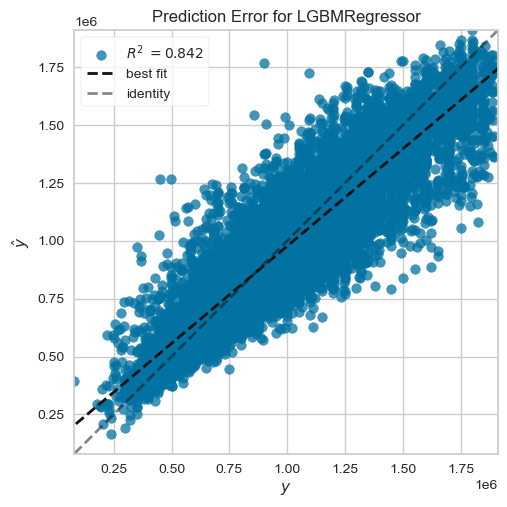

In [43]:
exp.plot_model(best_tuned_model, plot='error')

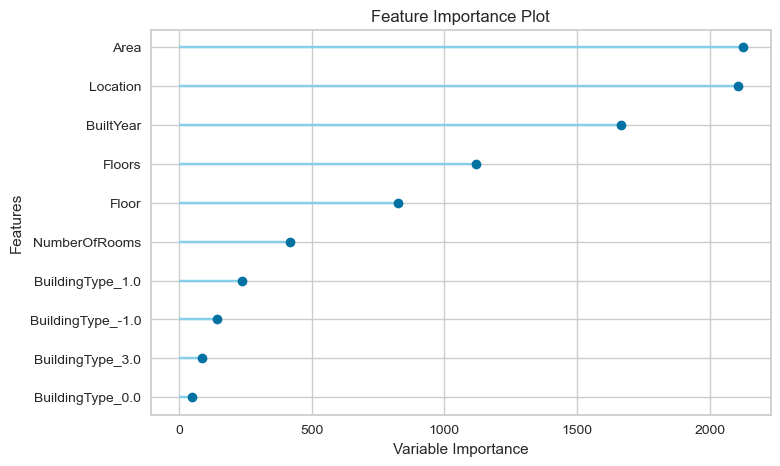

In [44]:
exp.plot_model(best_tuned_model, plot='feature')

In [45]:
best_final_model = exp.finalize_model(best_tuned_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Area', 'NumberOfRooms',
                                             'BuiltYear', 'Floor', 'Floors'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['BuildingType',
                                             'BuildingCondition'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerW...
                                    transformer=OneHotEncoder(cols=['BuildingType',
                                                                    'BuildingCondition'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=4,
                               feature_fraction=0.6, learning_rate=0.2,
                               min_child_samples=96, min_split_gain=0.8,
                               n_estimators=180, n_jobs=-1, num_leaves=50,
                               random_state=1122, reg_alpha=0.5,
                               reg_lambda=0.01))])

In [46]:
exp.save_model(best_final_model, "best_price_modelLGBM", verbose=False);

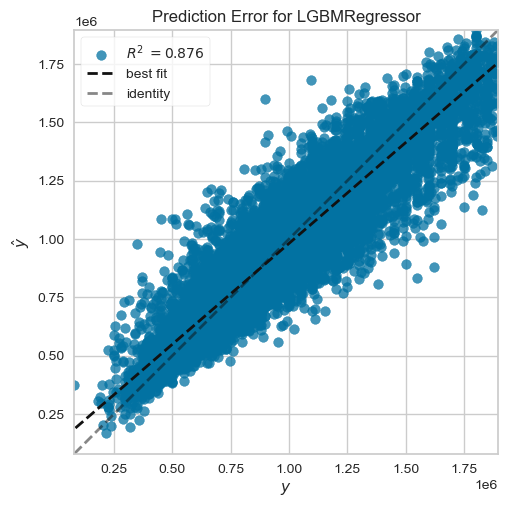

In [47]:
exp.plot_model(best_final_model, plot='error')

In [48]:
exp.predict_model(best_final_model).head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,73860.8857,10915841452.8964,104478.9043,0.8764,0.1181,0.0880


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,Description,Area,NumberOfRooms,BuiltYear,BuildingType,BuildingCondition,Floor,Floors,Location,Price,prediction_label
53051,PRZYJAZNE MIESZKANIE 2-POKOJOWE Z WIDOKIEM NA ...,49.000000,2.0,1971.0,Blok,NaN,5.0,10.0,"Mazowieckie, Warszawa, Praga-południe, Ul. Mię...",880000.0,7.904581e+05
20512,Sprzedam Mieszkanie w Doskonałej Lokalizacji n...,35.000000,2.0,NaN,Blok,NaN,6.0,NaN,"Mazowieckie, Warszawa, Ochota",609000.0,6.579642e+05
292,4-pokojowe mieszkanie numer 28A na 1. piętrze ...,73.000000,4.0,NaN,NaN,NaN,1.0,2.0,"Mazowieckie, Warszawa, Białołęka, Ul. Gioacchi...",796650.0,9.024570e+05
28836,"Na sprzedaż oferuję przestronne, 3-pokojowe mi...",62.000000,3.0,2024.0,Apartamentowiec,NaN,0.0,3.0,"Mazowieckie, Warszawa, Białołęka, Białołęka Dw...",744000.0,8.636907e+05
5000,Lento Warszawa Nieruchomości Mieszkania Sprzed...,62.000000,2.0,2009.0,Blok,NaN,2.0,NaN,"Mazowieckie, Warszawa, Białołęka",629000.0,8.237884e+05
40232,Oferta aktualna - możliwość umówienia bezpiecz...,63.299999,3.0,2014.0,Blok,NaN,2.0,4.0,"Mazowieckie, Warszawa, Praga-południe",995000.0,1.105769e+06
41323,"NAJLEPSZE CENY, WYSOKI STANDARD , BEZ PROWIZJI...",53.880001,3.0,2023.0,Blok,NaN,0.0,3.0,"Mazowieckie, Warszawa, Białołęka, Nowodwory",735231.0,7.503159e+05
94018,Przedstawiam Państwu komfortowe mieszkanie 2-p...,59.459999,2.0,2009.0,Blok,NaN,1.0,9.0,"Mazowieckie, Warszawa, Bemowo, Ul. Górczewska",970000.0,9.708916e+05
89950,Przestrzenne mieszkanie na warszawskim Grochow...,84.000000,3.0,1983.0,Blok,NaN,6.0,19.0,"Mazowieckie, Warszawa, Praga-południe, Ul. Iga...",1100000.0,1.033358e+06
41467,3-pokojowe mieszkanie zlokalizowane na Targówk...,64.000000,3.0,1976.0,NaN,NaN,11.0,12.0,"Mazowieckie, Warszawa, Targówek, Ul. Kuflewska",880000.0,7.958955e+05


In [49]:
predictions = exp.predict_model(best_final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,73860.8857,10915841452.8964,104478.9043,0.8764,0.1181,0.0880


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [50]:
predicted_column = predictions['prediction_label']
print(predicted_column)

53051    7.904581e+05
20512    6.579642e+05
292      9.024570e+05
28836    8.636907e+05
5000     8.237884e+05
             ...     
17762    6.851668e+05
81854    6.626758e+05
5466     9.434900e+05
38007    8.275047e+05
31714    1.601742e+06
Name: prediction_label, Length: 25379, dtype: float64


In [51]:
print(predictions[['prediction_label']].applymap('{:,.0f}'.format))

      prediction_label
53051          790,458
20512          657,964
292            902,457
28836          863,691
5000           823,788
...                ...
17762          685,167
81854          662,676
5466           943,490
38007          827,505
31714        1,601,742

[25379 rows x 1 columns]


In [52]:
df_last=predictions[['prediction_label','Price', ]].applymap('{:,.0f}'.format)


In [53]:
df_last.to_csv('new_prices.csv')

In [54]:
print(df_last.columns)

Index(['prediction_label', 'Price'], dtype='object')


In [55]:
print(df_last.head())

      prediction_label    Price
53051          790,458  880,000
20512          657,964  609,000
292            902,457  796,650
28836          863,691  744,000
5000           823,788  629,000


In [56]:
df_last = df_last.reset_index()  
print(df_last.columns)  

Index(['index', 'prediction_label', 'Price'], dtype='object')


In [57]:
df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [58]:
saleflats_df = pd.read_csv('saleflats_3.csv')

In [59]:
new_prices_df = pd.read_csv('new_prices.csv')

In [60]:
print("saleflats_df.columns:", saleflats_df.columns.tolist())

saleflats_df.columns: ['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area', 'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice', 'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type', 'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors', 'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded', 'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore', 'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive', 'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber', 'EncryptedId']


In [61]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

new_prices_df.columns: ['Unnamed: 0', 'prediction_label', 'Price']


In [62]:
new_prices_df = new_prices_df.rename(columns={'Unnamed: 0': 'SaleID', 'Price': 'NewPrice'})

In [63]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

new_prices_df.columns: ['SaleID', 'prediction_label', 'NewPrice']


In [64]:
print(new_prices_df.columns)

Index(['SaleID', 'prediction_label', 'NewPrice'], dtype='object')


In [65]:
print(saleflats_df.columns)

Index(['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area',
       'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice',
       'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type',
       'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors',
       'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded',
       'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom',
       'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates',
       'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower',
       'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore',
       'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
       'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber',
       'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber',
       'EncryptedId'],
      dtype='object')


In [66]:
merged_df = pd.merge(
    saleflats_df,
    new_prices_df[['SaleID', 'NewPrice']],
    left_on='SaleId',  # Kolumna w saleflats_df
    right_on='SaleID',  # Kolumna w new_prices_df
    how='left'
)

In [67]:
merged_df

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId,SaleID,NewPrice
0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,NaN,692985.0,...,14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==,NaN,NaN
1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,NaN,NaN,...,14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=,NaN,NaN
2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,NaN,3500000.0,...,14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=,NaN,NaN
3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,NaN,NaN,1885000.0,...,14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=,49614.0,"1,665,000"
4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,NaN,950000.0,...,14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,1043500.00,1322333.33,NaN,...,14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=,NaN,NaN
104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,629000.00,651666.67,NaN,...,14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=,NaN,NaN
104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,782389.08,875268.63,NaN,...,14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=,NaN,NaN
104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,1499000.00,1579933.33,NaN,...,14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=,NaN,NaN


In [68]:
# Krok 2: usuwanie dodatkowej kolumny klucza (opcjonalnie, bo mamy już 'SaleId')
merged_df.drop(columns=['SaleID'], inplace=True)

# Krok 3: przestawienie kolumny 'NewPrice' obok 'Price'
cols = merged_df.columns.tolist()

# znajdź indeks kolumny 'Price'
price_index = cols.index('Price')

# usuń NewPrice z listy i dodaj ją zaraz po Price
cols.remove('NewPrice')
cols.insert(price_index + 1, 'NewPrice')

# ustaw nową kolejność kolumn
merged_df = merged_df[cols]

In [69]:
prediction_df = merged_df.copy()

In [70]:
from pycaret.regression import predict_model

In [71]:
prediction_df_clean = prediction_df.drop(columns=['Price'], errors='ignore')
predictions = predict_model(best_final_model, data=prediction_df_clean)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [72]:
predictions['RealPrice'] = prediction_df['Price']

In [73]:
merged_df['PredictedPrice'] = predictions['prediction_label']

In [74]:
predictions=predictions[['prediction_label',]].applymap('{:,.0f}'.format)

In [75]:
# Przenieś kolumnę 'PredictedPrice' za 'NewPrice'
cols = list(merged_df.columns)
new_price_index = cols.index('NewPrice')
# Usuń z listy kolumn
cols.remove('PredictedPrice')
# Dodaj w odpowiednie miejsce
cols.insert(new_price_index + 1, 'PredictedPrice')
# Przekształć DataFrame
merged_df = merged_df[cols]

In [76]:
merged_df.to_csv('new_prices_full.csv')

In [77]:
merged_df = pd.read_csv('new_prices_full.csv')

In [78]:
merged_df

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,NewPrice,PredictedPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,7.409674e+05,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,8.000679e+05,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,1.928742e+06,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,"1,665,000",1.805211e+06,...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,1.223579e+06,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,NaN,7.894838e+05,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=
104578,104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,NaN,6.478669e+05,...,NaN,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Stru...",14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=
104579,104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,NaN,7.556070e+05,...,NaN,"Mazowieckie, Warszawa, Ursus",14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=
104580,104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,NaN,1.098029e+06,...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=


In [79]:
merged_df2=merged_df[['PredictedPrice',]].applymap('{:,.0f}'.format)

In [80]:
merged_df2

,PredictedPrice
0,"740,967"
1,"800,068"
2,"1,928,742"
3,"1,805,211"
4,"1,223,579"
...,...
104577,"789,484"
104578,"647,867"
104579,"755,607"
104580,"1,098,029"


In [81]:
merged_df['PredictedPrice'] = merged_df2['PredictedPrice']

In [82]:
merged_df

,Unnamed: 0,SaleId,OriginalId,PortalId,Title,Description,Area,Price,NewPrice,PredictedPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,"740,967",...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,"800,068",...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,"1,928,742",...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,"1,665,000","1,805,211",...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,"1,223,579",...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,NaN,"789,484",...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=
104578,104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,NaN,"647,867",...,NaN,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Stru...",14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=
104579,104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,NaN,"755,607",...,NaN,"Mazowieckie, Warszawa, Ursus",14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=
104580,104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,NaN,"1,098,029",...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=


In [84]:
merged_df.drop(columns=['NewPrice'], inplace=True)

In [85]:
merged_df.to_csv('new_prices_full.csv')

In [ ]:
# Wyciągnij wiersze, gdzie Price jest null
df_null_price = df[df['Price'].isna()]

# Wyciągnij wiersze, gdzie Price nie jest null (pozostaną takie same)
df_non_null_price = df[df['Price'].notna()]

# Usuń kolumnę 'Price' tylko z tych wierszy, gdzie Price jest null
df_null_price_without_price = df_null_price.drop(columns=['Price'])

# Zastosuj model do danych, gdzie Price jest null
predictions = predict_model(best_final_model, data=df_null_price_without_price)

# Zaktualizuj kolumnę 'Price' w df_null_price na podstawie przewidywanych cen
df_null_price['Price'] = predictions['prediction_label']
df_null_price=df_null_price[['Price',]].applymap('{:,.0f}'.format)

# Połącz ponownie te wiersze z df_non_null_price
df_updated = pd.concat([df_non_null_price, df_null_price], axis=0)

# Zresetuj indeks, jeśli jest potrzeba
df_updated = df_updated.sort_index()


In [ ]:
df_updated

In [ ]:
df_updated.to_csv('new_prices_FULL2.csv')